<a href="https://colab.research.google.com/github/yeb2Binfang/ECE-GY9123_DL/blob/main/HW/HW5/hw5prob3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this exercise we will train a simple Q-network in TensorFlow to solve Tic Tac Toe.

In [1]:
import random
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Hopefully everyone has played Tic Tac Toe at some point. Here is a [reminder](https://en.wikipedia.org/wiki/Tic-tac-toe). Let us set up some helper functions to define the game itself. The typical board size is 3x3 but we will be general.

In [2]:
def new_board(size):
    return np.zeros(shape=(size, size))

In [3]:
def available_moves(board):
    return np.argwhere(board == 0)

In [4]:
def check_game_end(board):
    best = max(list(board.sum(axis=0)) +    # columns
               list(board.sum(axis=1)) +    # rows
               [board.trace()] +            # main diagonal
               [np.fliplr(board).trace()],  # other diagonal
               key=abs)
    if abs(best) == board.shape[0]: 
        return np.sign(best)  # winning player, +1 or -1
    if available_moves(board).size == 0:
        return 0  # a draw (otherwise, return None by default)

Now, let's define our players. We will define three types of bots. A *random* player picks a random position in the board each move.

In [5]:
class Player():
    def new_game(self):
        pass
    def reward(self, value):
        pass

class RandomPlayer(Player):
    def move(self, board):
        return random.choice(available_moves(board))

A *boring* player always picks the *first* available position on the board (measured from top-left to bottom-right).

In [6]:
class BoringPlayer(Player):
    def move(self, board):
        return available_moves(board)[0]

We can simulate games by playing one bot vs another. The starting player is labeled +1.

In [7]:
def play(board, player_objs):
    for player in [+1, -1]:
        player_objs[player].new_game()
    player = +1
    game_end = check_game_end(board)
    while game_end is None:
        move = player_objs[player].move(board)
        board[tuple(move)] = player
        game_end = check_game_end(board)
        player *= -1  # switch players after each move
    for player in [+1, -1]:
        # the reward for wins is +1, and -1 for draws/losses
        reward_value = +1 if player == game_end else -1
        player_objs[player].reward(reward_value)
    return game_end

In [8]:
# 3x3, random vs. random
random.seed(1)

# TODO Q1. Play 2000 games between two bots, both of them random players.
# Print the number of wins by Player 1, number of wins by Player 2, and draws.
# Plot (as a function of game index) the moving average of game outcomes
# over a window of size 500. 
# You might find the following functions helpful for plotting.
results = [play(new_board(3), {+1: RandomPlayer(), -1: RandomPlayer()}) for _ in range(2000)]
collections.Counter(results)

Counter({-1.0: 564, 0: 242, 1.0: 1194})

In [10]:
def moving(data, value=+1, size=100):# calculates a moving average
    binary_data = [x == value for x in data]
    return [sum(binary_data[i-size:i])/size for i in range(size, len(data) + 1)]

In [11]:
def show(results, size=500, title='Moving average of game outcomes',
         first_label='First Player Wins', second_label='Second Player Wins', draw_label='Draw'):
    x_values = range(size, len(results) + 1)
    first = moving(results, value=+1, size=size)
    second = moving(results, value=-1, size=size)
    draw = moving(results, value=0, size=size)
    first, = plt.plot(x_values, first, color='red', label=first_label)
    second, = plt.plot(x_values, second, color='blue', label=second_label)
    draw, = plt.plot(x_values, draw, color='grey', label=draw_label)
    plt.xlim([0, len(results)])
    plt.ylim([0, 1])
    plt.title(title)
    plt.legend(handles=[first, second, draw], loc='best')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    ax.xaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.ylabel(f'Rate over last {size} games')
    plt.xlabel('Game index')
    plt.show()

Here will plot the results. Totally, we play 2000 games

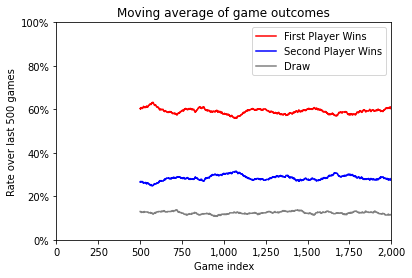

In [13]:
show(results)

In [32]:
# 3x3, random vs. boring

# TODO Q2. Play 2000 games between two bots, where Player 1 is Random and Player 2 is Boring.
random.seed(2)
results2 = [play(new_board(3), {+1: RandomPlayer(), -1: BoringPlayer()}) for _ in range(2000)]
collections.Counter(results2)
# Print the number of wins by Player 1, number of wins by Player 2, and draws.


Counter({-1.0: 891, 0: 76, 1.0: 1033})

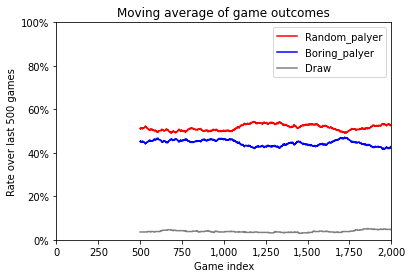

In [34]:
# Plot (as a function of game index) the moving average of game outcomes.
show(results2,first_label="Random_palyer",second_label="Boring_palyer")
# Comment on the results. Compare with your plot above. 
#Think about why this might be happening and explain your reasons.

Obviously, 

We will now use Q-learning using a neural network to train an RL agent. 

The Q-function will be parametrically represented via a very simple single layer with linear activations (essentially, a linear model).

Complete the Q-learning part in the code snippet below.



In [25]:
class Agent(Player):

    # Define single layer Q-network, MSE loss, and SGD optimizer
    def __init__(self, size, seed):
        self.size = size
        self.training = True
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(
            size**2,
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed)))
        self.model.compile(optimizer='sgd', loss='mean_squared_error')

    # Helper function to predict the Q-function
    def predict_q(self, board):
        return self.model.predict(
            np.array([board.ravel()])).reshape(self.size, self.size)

    # Helper function to train the network
    def fit_q(self, board, q_values):
        self.model.fit(
            np.array([board.ravel()]), np.array([q_values.ravel()]), verbose=0)

    # The agent preserves history, which is reset when a new game starts.
    def new_game(self):
        self.last_move = None
        self.board_history = []
        self.q_history = []

    # TODO Q3: Implement the "move" method below.
    # The "move" method should use the output of the Q-network 
    # that you defined above to pick the next best move.
    # Make sure you are only picking "legal" moves. 

    def move(self, board):
        # ... COMPLETE THIS
        q_values = self.predict_q(board)
        temp_q = q_values.copy()
        temp_q[board != 0] = temp_q.min() - 1  # no illegal moves
        move = np.unravel_index(np.argmax(temp_q), board.shape)
        value = temp_q.max()
        if self.training and self.last_move is not None:
            self.reward(value)
        self.board_history.append(board.copy())
        self.q_history.append(q_values)
        self.last_move = move
        return move

    # After picking the move, we call the reward method.
    # The reward method trains the Q-network, updating the Q-values with 
    # a new estimate for the last move. This is the Bellman update.
    def reward(self, reward_value):
        if not self.training:
            return
        new_q = self.q_history[-1].copy()
        new_q[self.last_move] = reward_value
        self.fit_q(self.board_history[-1], new_q)

In [27]:
# 3x3, q-learning vs. random

# TODO Q4. Play 2000 games, where Player 1 is a Q-network and Player 2 is Random.
# Print the number of wins by Player 1, number of wins by Player 2, and draws.
# Plot (as a function of game index) the moving average of game outcomes.
random.seed(3)
Q_network_player = Agent(3, seed=3)
results3 = [play(new_board(3), {+1: Q_network_player, -1: RandomPlayer()}) for _ in range(2000)]
collections.Counter(results3)

Counter({-1.0: 272, 0: 76, 1.0: 1652})

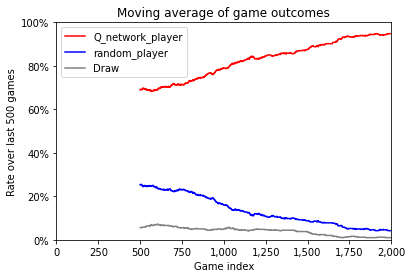

In [29]:
show(results3,first_label='Q_network_player',second_label="random_player")